In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My\ Drive

/content/drive/My Drive


In [3]:
!ls

 52061031.pdf		    'Image Segmentation.ipynb'
 ADITYA.pdf		     IMG_20200131_213657__01__01.jpg
 Assignment12		    'kfp images'
 Assignment-13		     maskoverlay.rar
'Assignment 15'		     maskoverlay.zip
 Assignment-9		     MobileBill_1047681785_249090639_7760630790.pdf
'Cat-2014 admit card.pdf'    MobileBill_1047681785_612303333_7760630790.pdf
'Colab Notebooks'	     Model
 Cover_letter.gdoc	     overlay.rar
 data			     overlay.zip
 DenseDepth		    'Pavan Model'
 DenseDepth1		     PyPackage
 depth.zip		     runs
'Dice Loss Small.ipynb'      test_indices.npy
'Google Photos'		     test.jpg
 Harid_FeatureTracking.pdf   weights
 hvc_data.zip		     YoloV3_Annotation_Tool
 hvc_encoded.csv


In [0]:
import torch
cuda_check = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_check else "cpu")

In [0]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18()
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [0]:
# Define the convolutional block
# First we define the convolutional block so we do not need to re-write it every time
import torch.nn.functional as F
import torch
import torch.nn as nn
from torchvision import models
class conv_block(nn.Module):
    """
    Define the convolutional - batch norm - relu block to avoid re-writing it
    every time
    """

    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_size, out_size, kernel_size,
                              padding=padding, stride=stride)
        self.bn = nn.BatchNorm2d(out_size)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))


# Define the network
# Then we define the network keeping in mind that down_1 output size should match with
# the scaled output of up_2, while down_2 size should match with the scaled output of the middle 
# convolution of the u-net model.
class small_UNET_256(nn.Module):
    """
    Define UNET model that accepts a 256 input and mostly uses 3x3 kernels
    with stride and padding = 1. It reduces the size of the image to 8x8 pixels
    ** It might not work if the input 'x' is not a square.
    """

    def __init__(self, n_channels):
        super(small_UNET_256, self).__init__()

        self.down_1 = nn.Sequential(
            conv_block(n_channels, 16),
            conv_block(16, 32, stride=2, padding=1))

        self.down_2 = nn.Sequential(
            conv_block(32, 64),
            conv_block(64, 128))

        self.middle = conv_block(128, 128, kernel_size=1, padding=0)

        self.up_2 = nn.Sequential(
            conv_block(256, 128),
            conv_block(128, 32))

        self.up_1 = nn.Sequential(
            conv_block(64, 64),
            conv_block(64, 32))

        self.output = nn.Sequential(
            conv_block(32, 16),
            conv_block(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        out = F.upsample(out, scale_factor=2)
        return self.output(out)

In [0]:
class Hybrid(nn.Module):
  def __init__(self):
    super(Hybrid, self).__init__()
    self.model1 = small_UNET_256(n_channels = 3)
    self.model2 = small_UNET_256( n_channels= 4)
    self.merge = nn.Conv2d(4, 1, 1,
                              padding=0)  
  
  def forward(self, x):
    # seg = self.model1(x)
    # cat = torch.cat((x,seg),1)
    dep = self.model1(x)
    # print(dep.shape)
    # dep = self.merge(dep)

    return dep



In [0]:
import os
import glob
from torch.utils.data import Dataset
from PIL import Image
import PIL.ImageOps 
class DataProducer(Dataset):
    def __init__(self, root_folder, transformFG=None, transformRest=None):
        
        self.background_images = list((root_folder / 'bg').glob('*.jpg'))
        self.foreground_images = list((root_folder / 'fg').glob('*.jpg'))
        self.mask_images = list((root_folder / 'mask').glob('*.jpg'))
        self.depth_images = list((root_folder / 'depth').glob('*.jpg'))
        self.transform = transformFG
        self.transformRest = transformRest
    
    def __len__(self):
        return len(self.foreground_images)
    
    def __getitem__(self, index):
        fg_image = Image.open(self.foreground_images[index])
        fg_image = fg_image.resize((64,64))
        # print(self.foreground_images[index])
        bg_image = Image.open(self.get_background_image(self.foreground_images[index]))
        bg_image = bg_image.resize((64,64))
        mask_image = Image.open(self.get_mask_image(self.foreground_images[index])).convert('L')
        mask_image = mask_image.resize((64,64))
        depth_image = Image.open(self.get_depth_image(self.foreground_images[index])).convert('L')
        depth_image = PIL.ImageOps.invert(depth_image)
        depth_image = depth_image.resize((64,64))
        # Do transformation
        
        # if self.transform:
        fg_image = self.transform(fg_image)
        bg_image = self.transformRest(bg_image)
        mask_image = self.transformRest(mask_image)
        depth_image = self.transformRest(depth_image)
        
        return { 'bg': bg_image, 'fg': fg_image, 'mask' : mask_image, 'depth': depth_image}
    
    def get_background_image(self, fg_image_path):
        file_name = str(fg_image_path).lstrip('data/fg/')
        # print('file after lstrip', file_name)
        index = file_name.find('_')
#         if ( index == -1)
        file_name = file_name[:index] + '.jpg'
        # print(file_name)
        return root_folder / 'bg' / file_name
    
    def get_mask_image(self, fg_image_path):
        file_name = 'mask_' + str(fg_image_path).lstrip('data/fg/')
        # print('mask file - ' , file_name)
        return root_folder / 'mask' / file_name

    def get_depth_image(self, fg_image_path):
        file_name = 'depth_' + str(fg_image_path).lstrip('data/fg/')
        # print('mask file - ' , file_name)
        return root_folder / 'depth' / file_name
                                         

In [0]:
from torchvision.transforms import transforms

transform = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49737222, 0.49328762, 0.46562814), (0.21714624, 0.21749634, 0.23051126)),
                                 
])

In [0]:
from torchvision.transforms import transforms

transformRest = transforms.Compose([
             
                                 transforms.ToTensor(),
])

In [0]:
from torchvision.transforms import transforms
from pathlib import Path
root_folder = Path('./data/')#os.path.join(os.getcwd(),'data')
train_set = DataProducer(root_folder, transform, transformRest)

In [12]:
print(root_folder)

data


In [0]:
# a  = train_set[0]["mask"]
# b = a.reshape(1,1,64,64)
# a = a.reshape(1,1,64,64)
# c = torch.cat((a,b),dim=1)
# print(c.shape)



In [0]:
# import matplotlib.pyplot as plt
# import torchvision
# # plt.title('Plots')

# f, axarr = plt.subplots(1,2)

# axarr[0].set_title('Epoch : {}'.format(10))
# axarr[0].imshow(torchvision.utils.make_grid(train_set[0]["fg"]).permute(1, 2, 0))
# axarr[1].imshow(torchvision.utils.make_grid(train_set[0]["depth"]).permute(1, 2, 0))
# plt.axis('off')

# plt.savefig('test.jpg')
# plt.show()

In [15]:
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)


In [0]:
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# plt.figure(figsize = (10,10))

# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

# for i in range(16):
#    # i = i + 1 # grid spec indexes from 0
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')
#     ax1.imshow(torchvision.utils.make_grid(train_set[i]["depth"]).permute(1, 2, 0))
# plt.suptitle('Original Image')
# plt.show()

In [0]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_set, batch_size=16, shuffle= False)

In [0]:
# sample = next(iter(train_dl))

In [0]:
# criterion = torch.nn.SmoothL1Loss()

In [0]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [0]:
# criterion = dice_loss

In [0]:
model = ResNetUNet(n_class=1)
# model = small_UNET_256(n_channels=3)
# model = Hybrid()
model = model.to(device)

In [23]:
from torchsummary import summary
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]           9,408
            Conv2d-6           [-1, 64, 32, 32]           9,408
       BatchNorm2d-7           [-1, 64, 32, 32]             128
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
             ReLU-10           [-1, 64, 32, 32]               0
        MaxPool2d-11           [-1, 64, 16, 16]               0
        MaxPool2d-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,864
           Conv2d-14           [-1, 64,

In [0]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs')
# writer.add_scalar('training loss', 10)


In [0]:
# import matplotlib.pyplot as plt
# import torchvision
# import matplotlib.gridspec as gridspec
# def show(segment_tensors, depth_tensors, original_seg_tensors, original_depth_tensors, epoch, fig_size=(10,10), *args, **kwargs):
#   # try:
#   #   tensors = tensors.detach().cpu()
#   # except:
#   #   pass
#   # grid_tensor = torchvision.utils.make_grid(output_tensors, *args, **kwargs)
#   # grid_image = grid_tensor.permute(1,2,0)
#   # # plt.figure(fig_size=fig_size)
#   # # print(tensors.shape)
#   # # print(tensors[0].shape)
#   # # plt.imshow(torchvision.utils.make_grid(tensors[0]).permute(1,2,0))
#   # # plt.show()
#   # f, axarr = plt.subplots(2,2)
#   # axarr[0,0].imshow(torchvision.utils.make_grid(original_tensors[0]).permute(1, 2, 0))
#   # axarr[0,0].set_title('Epoch : {}'.format(epoch))
#   # axarr[0,1].imshow(torchvision.utils.make_grid(output_tensors[0]).permute(1, 2, 0))
#   # axarr[1,0].imshow(torchvision.utils.make_grid(original_tensors[1]).permute(1, 2, 0))
#   # axarr[1,1].imshow(torchvision.utils.make_grid(output_tensors[1]).permute(1, 2, 0))
#   # import matplotlib.pyplot as plt

#   size = 10
#   plt.figure(figsize = (10,10))
#   if segment_tensors.shape[0] < size:
#     size = segment_tensors.shape[0]
#   gs1 = gridspec.GridSpec(1, size)
#   gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

#   # for i in range(size):

#   #  # i = i + 1 # grid spec indexes from 0
#   #   ax1 = plt.subplot(gs1[i])
#   #   plt.axis('on')
#   #   ax1.set_xticklabels([])
#   #   ax1.set_yticklabels([])
#   #   ax1.set_aspect('equal')
#   #   ax1.imshow(torchvision.utils.make_grid(original_seg_tensors[i]).permute(1, 2, 0))
#   # plt.suptitle('Epoch : {} -- Original Images'.format(epoch))
#   # plt.show()
#   # # writer.add_image('Original Image', gs1, epoch)
#   # plt.figure(figsize = (10,10))

#   # gs1 = gridspec.GridSpec(1, size)
#   # gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

#   # for i in range(size):

#   #  # i = i + 1 # grid spec indexes from 0
#   #   ax1 = plt.subplot(gs1[i])
#   #   plt.axis('on')
#   #   ax1.set_xticklabels([])
#   #   ax1.set_yticklabels([])
#   #   ax1.set_aspect('equal')
#   #   ax1.imshow(torchvision.utils.make_grid(segment_tensors[i]).permute(1, 2, 0))
#   # plt.suptitle('Epoch : {} -- Predicted Images'.format(epoch))
#   # plt.show()

#   plt.figure(figsize = (10,10))
#   gs1 = gridspec.GridSpec(1, size)
#   gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

#   for i in range(size):

#    # i = i + 1 # grid spec indexes from 0
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')
#     ax1.imshow(torchvision.utils.make_grid(original_depth_tensors[i]).permute(1, 2, 0))
#   plt.suptitle('Epoch : {} -- Original Images'.format(epoch))
#   plt.show()
#   # writer.add_image('Original Image', gs1, epoch)
#   plt.figure(figsize = (10,10))

#   gs1 = gridspec.GridSpec(1, size)
#   gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

#   for i in range(size):

#    # i = i + 1 # grid spec indexes from 0
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')
#     ax1.imshow(torchvision.utils.make_grid(depth_tensors[i]).permute(1, 2, 0))
#   plt.suptitle('Epoch : {} -- Predicted Images'.format(epoch))
#   plt.show()

In [0]:
import matplotlib.pyplot as plt
import torchvision
import matplotlib.gridspec as gridspec
def show(segment_tensors, depth_tensors, original_seg_tensors, original_depth_tensors, epoch, fig_size=(10,10), *args, **kwargs):
  size = 10
  plt.figure(figsize = (10,10))
  if segment_tensors.shape[0] < size:
    size = segment_tensors.shape[0]
  gs1 = gridspec.GridSpec(2, size)
  gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

  counter = -1

  # for i in range(size):

  #   counter = counter + 1
  #   ax1 = plt.subplot(gs1[counter])
  #   plt.axis('on')
  #   ax1.set_xticklabels([])
  #   ax1.set_yticklabels([])
  #   ax1.set_aspect('equal')
  #   ax1.imshow(torchvision.utils.make_grid(original_seg_tensors[i]).permute(1, 2, 0))

  # for i in range(size):
  #   counter = counter + 1
  #   ax1 = plt.subplot(gs1[counter])
  #   plt.axis('on')
  #   ax1.set_xticklabels([])
  #   ax1.set_yticklabels([])
  #   ax1.set_aspect('equal')
  #   ax1.imshow(torchvision.utils.make_grid(segment_tensors[i]).permute(1, 2, 0))

  for i in range(size):
    counter = counter + 1
    ax1 = plt.subplot(gs1[counter])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(torchvision.utils.make_grid(original_depth_tensors[i]).permute(1, 2, 0))


  for i in range(size):
    counter = counter + 1
    ax1 = plt.subplot(gs1[counter])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.imshow(torchvision.utils.make_grid(depth_tensors[i]).permute(1, 2, 0))
  

  # fig, ax = plt.subplots(nrows=2, ncols=size, sharex=True, sharey=True,)
  # ax = ax.flatten()
      
  # for jdx in range(size): 
  #   ax[0,jdx].imshow(torchvision.utils.make_grid(original_depth_tensors[jdx]).permute(1, 2, 0))
  #   ax[1,jdx].imshow(torchvision.utils.make_grid(depth_tensors[jdx]).permute(1, 2, 0))
  plt.show()

In [27]:
os.getcwd()

'/content/drive/My Drive'

In [0]:
criterion = torch.nn.L1Loss()

# from kornia.losses import SSIM

In [0]:
def train(model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, data in enumerate(train_loader):
    data["fg"] = data["fg"].to(device)
    data["bg"] = data["bg"].to(device)
    data["mask"] = data["mask"].to(device)
    data["depth"] = data["depth"].to(device)
    
    optimizer.zero_grad()

    # data["depth"] = 1000/data["depth"]



    # cat = torch.cat((data["fg"],data["mask"]),1)
    dep = model(data["fg"])
    
    # print(output.shape)

    

    loss1 = criterion(dep, data["depth"])
    # loss2 = dice_loss(dep, data["depth"])
    # loss = loss1 + 0.1 *loss2
    loss1.backward()
    optimizer.step()
  if epoch % 50 == 0 :
    show(dep.detach().cpu(),dep.detach().cpu(),data["mask"].detach().cpu(),data["depth"].detach().cpu(),epoch, nrow=4)    

In [0]:
# def test(model, criterion, device, test_loader):
#   model.eval()
#   test_loss = 0
#   correct = 0

#   with torch.no_grad():
#     for data in test_loader:
#       data["fg"] = data["fg"].to(device)
#       data["bg"] = data["bg"].to(device)
#       data["mask"] = data["mask"].to(device)
#       output = model(data["fg"])

#       test_loss += criterion(output, data["mask"], reduction='sum' ).item()
#       pred = output.argmax(dim=1, keepdim=True)
#       correct += pred.eq(target.view_as(pred)).sum().item()

#       show(output.cpu(), nrow=2)
#     test_loss /= len(test_loader.dataset)
#     show(output.detach().cpu(), nrow=4)

In [0]:
optim = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=.9, weight_decay=1e-5)

In [0]:
model = model.to(device)

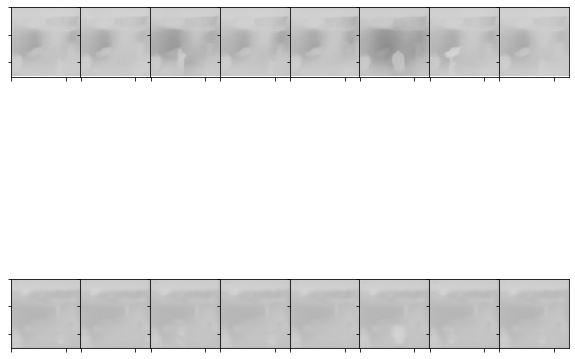

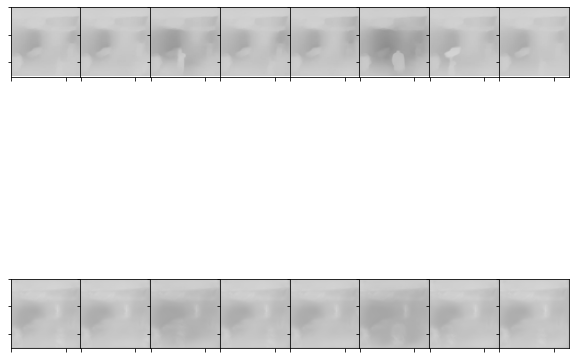

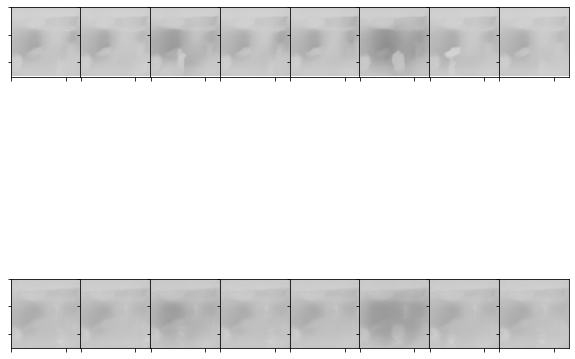

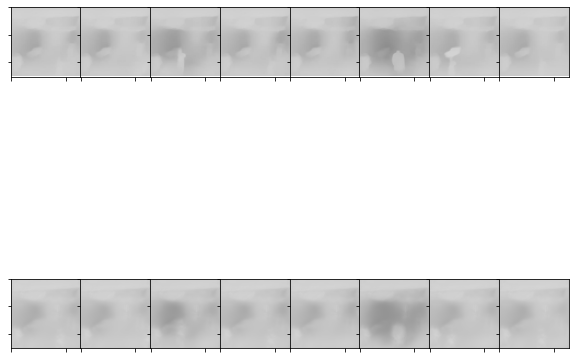

In [33]:
for epoch in range(1,201):
  train(model, criterion, device, train_dl, optim, epoch)

In [0]:
# writer.close()